In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


# `Week2 - Dataset`

### **1. Import Libraries**

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import shutil
import random
import pandas as pd
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomRotation, RandomHorizontalFlip
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from PIL import Image

### **2. Frame Extraction and Data Organization**

#### Define Function to Extract Frames

In [ ]:
def extract_frames(video_path, output_folder, frame_count= 20):
    """
    Extract a specified number of frames from a video and save them to the destination folder.
    Deletes the original video file after extraction.

    Parameters:
    - video_path (str): Path to the video file.
    - output_folder (str): Folder to save the extracted frames.
    - frame_count (int): Number of frames to extract from the video. Default is 10.
    """
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  # Uniform sampling

    frame_count_extracted = 0
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame_name = os.path.join(output_folder, f"frame_{frame_count_extracted}.jpg")
        cv2.imwrite(frame_name, frame)
        frame_count_extracted += 1

    cap.release()

    # Remove the video file after frame extraction
    print(f"Extracted {frame_count_extracted} frames from {video_path}")

#### Define Function to Split and Organize Data

In [ ]:
def split_data(src_folder, dest_folder, categories, train_ratio=0.8):
    """
    Split video data into training and testing sets, extract frames, and remove original video files.
    Saves organized data into `dest_folder`.
    """
    random.seed(42)
    metadata = {'path': [], 'label': [], 'split': []}

    for category in categories:
        category_folder = os.path.join(src_folder, category)
        if not os.path.exists(category_folder):
            print(f"Folder {category_folder} does not exist.")
            continue

        videos = os.listdir(category_folder)
        random.shuffle(videos)
        split_idx = int(train_ratio * len(videos))
        train_videos, test_videos = videos[:split_idx], videos[split_idx:]

        for split, video_list in zip(['train', 'test'], [train_videos, test_videos]):
            split_category_folder = os.path.join(dest_folder, split, category)
            os.makedirs(split_category_folder, exist_ok=True)

            for video in video_list:
                video_path = os.path.join(category_folder, video)
                video_output_folder = os.path.join(split_category_folder, video.split('.')[0])
                extract_frames(video_path, video_output_folder)

                for frame in os.listdir(video_output_folder):
                    metadata['path'].append(os.path.join(video_output_folder, frame))
                    metadata['label'].append(category)
                    metadata['split'].append(split)

    return pd.DataFrame(metadata)

### **3. Apply Transformations**

#### Define Transformation Pipeline

In [ ]:
def get_transforms():
    """
    Returns transformations for preprocessing and data augmentation.
    """
    return Compose([
        Resize((224, 224)),
        RandomRotation(15),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

transforms = get_transforms()

### **4. Check for Data Imbalance**

#### Define Function to Check Class Distribution

In [ ]:
def check_imbalance(dataframe):
    """
    Check for class imbalance in the dataset.
    """
    class_counts = dataframe['label'].value_counts()
    print("Class Distribution:")
    print(class_counts)
    return class_counts

### **5. Balance Dataset**

#### Define Function to Balance Dataset

In [ ]:
def balance_dataset(dataframe):
    """
    Balance the dataset by oversampling minority classes.
    """
    max_count = dataframe['label'].value_counts().max()
    balanced_data = []

    for label in dataframe['label'].unique():
        class_data = dataframe[dataframe['label'] == label]
        balanced_class_data = resample(
            class_data,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        balanced_data.append(balanced_class_data)

    balanced_df = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

### **6. Create Dataset and DataLoader**

#### Define Custom Dataset

In [ ]:
class VideoFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

#### Define Function to Create DataLoader

In [ ]:
def create_dataloader(dataframe, batch_size=32, shuffle=True):
    """
    Create DataLoader for given dataframe.
    """
    dataset = VideoFrameDataset(dataframe, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

### **7. Main Pipeline Dataset**

In [ ]:
import os

# Định nghĩa đường dẫn đến thư mục chứa dữ liệu
data_folder = "/content/drive/MyDrive/project/data"

# Kiểm tra thư mục có tồn tại không
if os.path.exists(data_folder):
    print(f"Thư mục {data_folder} tồn tại. Đang liệt kê các tệp...")

    # Duyệt qua tất cả các thư mục con và tệp trong thư mục chính
    for root, dirs, files in os.walk(data_folder):
        print(f"\n📂 Thư mục: {root}")
        for file in files[:5]:  # Chỉ in 5 tệp đầu tiên để tránh quá tải
            print(f"  📄 {file}")

else:
    print(f"❌ Thư mục {data_folder} không tồn tại. Vui lòng kiểm tra đường dẫn!")


Thư mục /content/drive/MyDrive/project/data tồn tại. Đang liệt kê các tệp...

📂 Thư mục: /content/drive/MyDrive/project/data

📂 Thư mục: /content/drive/MyDrive/project/data/fake
  📄 01_03__hugging_happy__ISF9SP4G.mp4
  📄 01_03__podium_speech_happy__480LQD1C.mp4
  📄 01_02__walk_down_hall_angry__YVGY8LOK.mp4
  📄 01_02__outside_talking_still_laughing__YVGY8LOK.mp4
  📄 01_11__secret_conversation__4OJNJLOO.mp4

📂 Thư mục: /content/drive/MyDrive/project/data/real
  📄 01__exit_phone_room.mp4
  📄 01__hugging_happy.mp4
  📄 01__kitchen_pan.mp4
  📄 01__meeting_serious.mp4
  📄 01__kitchen_still.mp4


In [ ]:
# Define source and destination folders
src_folder = "/content/drive/MyDrive/project/data"  # Source folder containing videos
dest_folder = 'organized_data2'  # Destination folder for organized data
categories = ['fake', 'real']

In [ ]:
# Step 1: Split data and extract frames
metadata_df = split_data(src_folder, dest_folder, categories)

Extracted 20 frames from /content/drive/MyDrive/project/data/fake/03_07__walking_outside_cafe_disgusted__CDSNLDQ8.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/09_13__kitchen_pan__21H6XSPE.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/04_06__kitchen_still__ZK95PQDE.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/09_20__kitchen_pan__98NUQ3E6.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/04_18__kitchen_still__NAXINA1N.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/06_07__exit_phone_room__NMGYPBXE.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/01_27__walking_outside_cafe_disgusted__ZYCZ30C0.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/01_02__walk_down_hall_angry__YVGY8LOK.mp4
Extracted 20 frames from /content/drive/MyDrive/project/data/fake/03_07__walk_down_hall_angry__IFSURI9X.mp4
Extracted 20 frames from /content/drive/MyDri

In [ ]:
# Step 2: Save metadata to CSV
metadata_df.to_csv('metadata2.csv', index=False)
print("Metadata saved to metadata2.csv")

Metadata saved to metadata2.csv


In [ ]:
# Step 3: Check for imbalance
print("Checking imbalance...")
check_imbalance(metadata_df)

Checking imbalance...
Class Distribution:
label
fake    4000
real    4000
Name: count, dtype: int64


,count
label,
fake,4000
real,4000


In [ ]:
# Step 4: Balance dataset
print("Balancing dataset...")
balanced_df = balance_dataset(metadata_df)

Balancing dataset...


In [ ]:
# Step 5: Save balanced dataset to CSV
balanced_df.to_csv('balanced_metadata2.csv', index=False)
print("Balanced metadata saved to balanced_metadata2.csv")

Balanced metadata saved to balanced_metadata2.csv


In [ ]:
import pandas as pd
balanced_df = pd.read_csv('balanced_metadata2.csv')

In [ ]:
# 1️⃣ Mã hóa nhãn trước khi tạo DataLoader
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
balanced_df['label'] = label_encoder.fit_transform(balanced_df['label'])

In [ ]:
label_mapping = pd.DataFrame({
    'original_label': label_encoder.classes_,
    'encoded_label': range(len(label_encoder.classes_))
})

print(label_mapping)

  original_label  encoded_label
0           fake              0
1           real              1


In [ ]:
# Step 6: Create DataLoader
train_df = balanced_df[balanced_df['split'] == 'train']
test_df = balanced_df[balanced_df['split'] == 'test']

train_loader = create_dataloader(train_df)
test_loader = create_dataloader(test_df, shuffle=False)

print("DataLoader is ready for use in training.")

DataLoader is ready for use in training.


torch.Size([32, 3, 224, 224]) tensor([1, 1, 1, 0, 0])


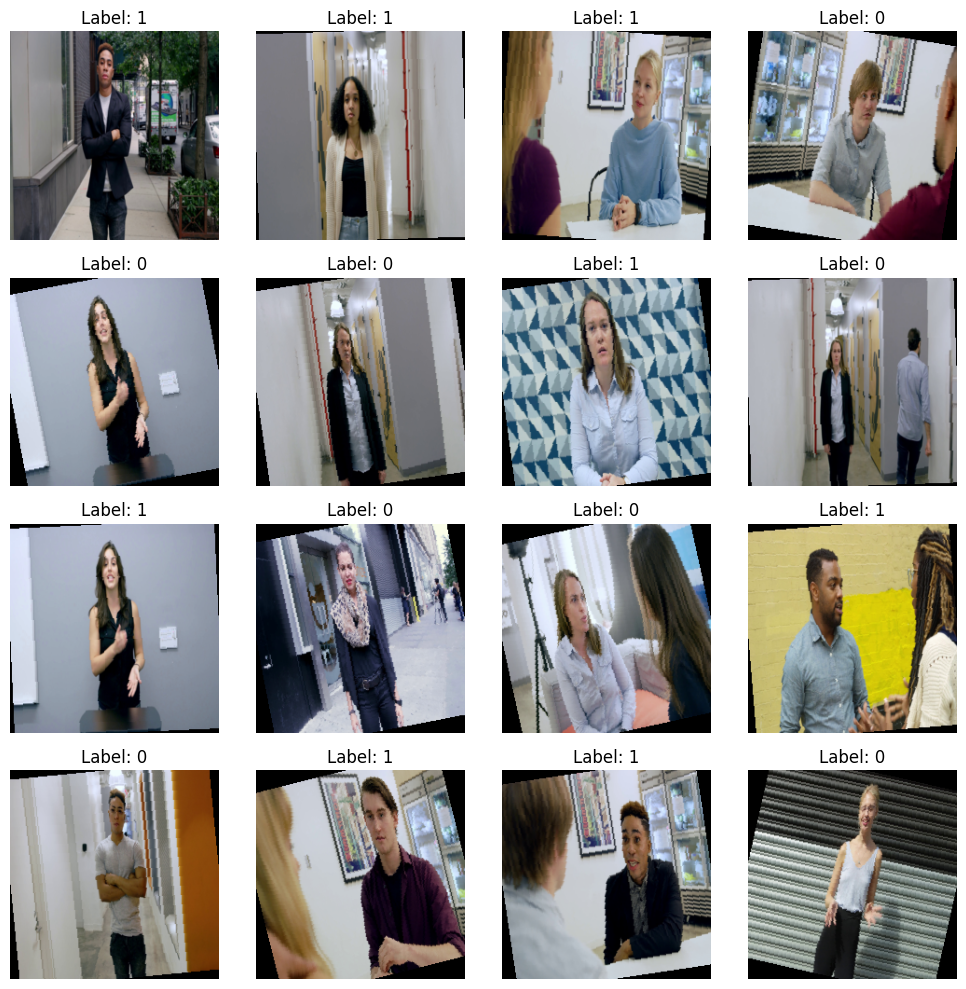

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Lấy một batch hình ảnh và nhãn từ train_loader
for images, labels in train_loader:
    print(images.shape, labels[:5])  # Kiểm tra kích thước dữ liệu
    break

# Số lượng ảnh muốn hiển thị
num_images = min(16, images.shape[0])  # Lấy tối đa 16 ảnh

# Chuyển ảnh từ tensor về numpy để hiển thị
images_np = images[:num_images].permute(0, 2, 3, 1).numpy()

# Hiển thị hình ảnh với nhãn
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes = axes.flatten()  # Chuyển ma trận thành danh sách để dễ duyệt

for i in range(num_images):
    ax = axes[i]
    img = images_np[i]

    # Chuẩn hóa ảnh về khoảng [0,1] nếu cần
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")  # Tắt trục tọa độ

plt.tight_layout()
plt.show()


# `Week3 - Building a Shallow Neural Network`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# Định nghĩa mô hình Shallow NN
class ShallowNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ShallowNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))  # Dùng ReLU
        x = torch.sigmoid(self.fc2(x)).squeeze(1)  # Đảm bảo đầu ra có kích thước phù hợp
        return x

In [ ]:
# Các siêu tham số
input_size = 150528  # Kích thước đầu vào giữ nguyên
hidden_size = 256   # Giảm số hidden units để tăng tốc độ
batch_size = 128  # Tăng batch size để tối ưu tốc độ
learning_rate = 0.001
epochs = 10  # Giảm số epochs để tăng hiệu suất


In [ ]:
# Khởi tạo mô hình
model = ShallowNN(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for inputs, labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.float().view_as(outputs)  # Đảm bảo labels có cùng kích thước với outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=total_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
def evaluate(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)
        for inputs, labels in progress_bar:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels.view_as(predicted)).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Chạy huấn luyện và đánh giá
train(model, train_loader, criterion, optimizer, epochs)

Epoch 1/10, Loss: 43.3658


Epoch 2/10, Loss: 49.8412


Epoch 3/10, Loss: 49.6799


Epoch 4/10, Loss: 49.7897


Epoch 5/10, Loss: 49.5441


Epoch 6/10, Loss: 49.6650


Epoch 7/10, Loss: 49.7399


Epoch 8/10, Loss: 49.8257


Epoch 9/10, Loss: 49.7993


Epoch 10/10, Loss: 49.8348


In [ ]:
evaluate(model, test_loader, criterion)

Test Accuracy: 50.31%


# Week 4: Designing the CNN

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Định nghĩa mô hình CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='softmax')
])
model.compile(loss='categorical_crossentropy',  # ✅ Đổi loss phù hợp với softmax
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
# Hiển thị kiến trúc mô hình
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Định nghĩa mô hình ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze một số tầng cuối để fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Xây dựng mô hình
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),  # Thêm Batch Normalization
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Biên dịch mô hình
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),  # Giảm learning rate
              metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator cho tập train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('/content/drive/MyDrive/project/balanced_metadata2.csv'),
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Generator cho tập validation
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('/content/drive/MyDrive/project/balanced_metadata2.csv'),
    directory=None,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    epochs=10,  # Tăng số epochs
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop]
)

# Đánh giá mô hình
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Lưu mô hình
model.save('resnet50_model_tf.h5')


Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1691s 8s/step - accuracy: 0.5948 - loss: 2.4020 - val_accuracy: 0.5031 - val_loss: 22.4966 - learning_rate: 1.0000e-04
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1678s 8s/step - accuracy: 0.6358 - loss: 1.4444 - val_accuracy: 0.4988 - val_loss: 0.8432 - learning_rate: 1.0000e-04
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1631s 8s/step - accuracy: 0.6367 - loss: 1.3351 - val_accuracy: 0.5025 - val_loss: 0.9154 - learning_rate: 1.0000e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1606s 8s/step - accuracy: 0.6137 - loss: 1.2825 - val_accuracy: 0.4981 - val_loss: 0.8700 - learning_rate: 1.0000e-04
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6358 - loss: 1.3326
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
200/200 ━━━━━━━━━━━━━━━━━━━━ 1555s 8s/step - accuracy: 0.6358 - loss: 1.3315 - val_a

Validation Accuracy: 69.00%


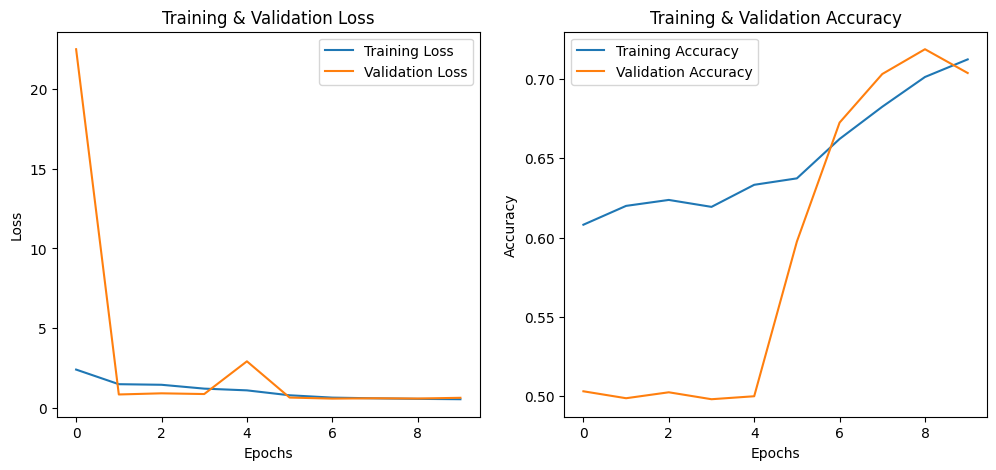

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()


# WEEK 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/project/Final DPL

/content/drive/MyDrive/project/Final DPL


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đọc dữ liệu
df = pd.read_csv('/content/drive/MyDrive/project/balanced_metadata2.csv')

# Thêm đường dẫn đầy đủ
base_path = "/content/drive/MyDrive/project/"
df['path'] = df['path'].apply(lambda x: base_path + x if not x.startswith('/') else x)

# Kiểm tra lại số lượng ảnh hợp lệ
print("Số lượng ảnh hợp lệ sau khi cập nhật đường dẫn:", len(df))
print(df.head())  # In thử 5 dòng đầu để kiểm tra

# Khởi tạo ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Tạo train_generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Tạo validation_generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

# Load pre-trained ResNet50 model (exclude top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build the model with BatchNorm, Dropout, and L2 Regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Sử dụng GAP thay vì Flatten để giảm tham số
    BatchNormalization(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),  # L2 Regularization
    Dropout(0.5),  # Dropout để giảm overfitting
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Thêm lớp Dense
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer
])

# Choose optimizer (Adam or SGD)
optimizer = Adam(learning_rate=0.0001)  # Thử Adam
# optimizer = SGD(learning_rate=0.001, momentum=0.9)  # Hoặc SGD với momentum

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/project/balanced_metadata2_fixed.csv')

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Callbacks: Reduce LR, EarlyStopping, Checkpoints, TensorBoard Logs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Tăng số epochs để tối ưu hóa
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop, checkpoint, tensorboard]
)

# Evaluate model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Save final model
model.save('resnet50_finetuned.keras')

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5701 - loss: 2.8757 
Epoch 1: val_accuracy improved from -inf to 0.49750, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 3787s 19s/step - accuracy: 0.5704 - loss: 2.8752 - val_accuracy: 0.4975 - val_loss: 2.7137 - learning_rate: 1.0000e-04
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.6849 - loss: 2.6198
Epoch 2: val_accuracy improved from 0.49750 to 0.51187, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 186s 928ms/step - accuracy: 0.6849 - loss: 2.6196 - val_accuracy: 0.5119 - val_loss: 2.6385 - learning_rate: 1.0000e-04
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.7168 - loss: 2.4889
Epoch 3: val_accuracy did not improve from 0.51187
200/200 ━━━━━━━━━━━━━━━━━━━━ 192s 955ms/step - accuracy: 0.7169 - loss: 2.4887 - val_accurac

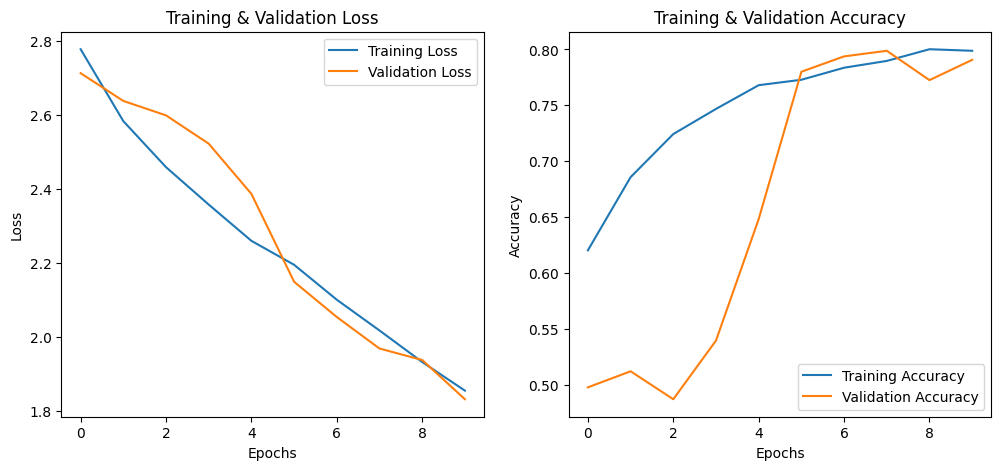

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# Vẽ biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()


# Week 6:

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load và tiền xử lý dữ liệu
file_path = "/content/drive/MyDrive/project/balanced_metadata2.csv"
base_path = "/content/drive/MyDrive/project/"
full_model = tf.keras.models.load_model("/content/drive/MyDrive/project/Final DPL/resnet50_finetuned.keras")

# Đọc file CSV
df = pd.read_csv(file_path)

# Xử lý đường dẫn ảnh
df['path'] = df['path'].apply(lambda x: os.path.join(base_path, x) if not x.startswith('/') else x)

# Kiểm tra ảnh hợp lệ
df['valid'] = df['path'].apply(lambda x: os.path.exists(x))
df = df[df['valid']].drop(columns=['valid'])

# Tải ảnh & chuẩn hóa
IMG_SIZE = (128, 128)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_and_preprocess_image(path):
    img = cv2.imread(path)
    if img is None:  # Kiểm tra nếu ảnh bị lỗi
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3))
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Chuẩn hóa về [0,1]
    return img
# Load ảnh vào mảng numpy
X = np.array([load_and_preprocess_image(p) for p in df['path']])

In [ ]:
# Load mô hình ResNet50 đã fine-tuned
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False


In [ ]:
# Xây dựng mô hình cho Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

    # Số lượng lớp ẩn và số filters mỗi lớp
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size', [3, 5]),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Sử dụng Keras Tuner để tìm siêu tham số tối ưu
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Tối ưu hóa độ chính xác trên tập validation
    max_trials=10,  # Số lần thử nghiệm
    executions_per_trial=1,
    directory='my_tuner',
    project_name='hyperparameter_tuning'
)

# Chạy tìm kiếm tham số
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

In [ ]:
# Lấy mô hình tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Best hyperparameters: {'num_layers': 1, 'filters_0': 32, 'kernel_size': 5, 'activation': 'relu', 'learning_rate': 0.001, 'filters_1': 224, 'filters_2': 224}


In [ ]:
# Huấn luyện mô hình tốt nhất
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 513ms/step - accuracy: 0.7390 - loss: 0.7172 - val_accuracy: 0.8211 - val_loss: 0.4117
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 507ms/step - accuracy: 0.8418 - loss: 0.3622 - val_accuracy: 0.8391 - val_loss: 0.3412
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 75s 464ms/step - accuracy: 0.8680 - loss: 0.2994 - val_accuracy: 0.8531 - val_loss: 0.3641
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 464ms/step - accuracy: 0.8885 - loss: 0.2544 - val_accuracy: 0.8547 - val_loss: 0.3197
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 87s 495ms/step - accuracy: 0.8976 - loss: 0.2350 - val_accuracy: 0.8555 - val_loss: 0.3670
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 494ms/step - accuracy: 0.9059 - loss: 0.2252 - val_accuracy: 0.8656 - val_loss: 0.3439
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 75s 469ms/step - accuracy: 0.9126 - loss: 0.1983 - val_accuracy: 0.8492 - val_loss: 0.3371
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 460ms/step - accuracy: 0.9169 - loss: 0

In [ ]:
# Đánh giá mô hình trên tập test
loss, acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8680 - loss: 0.3106
Test accuracy: 0.8562


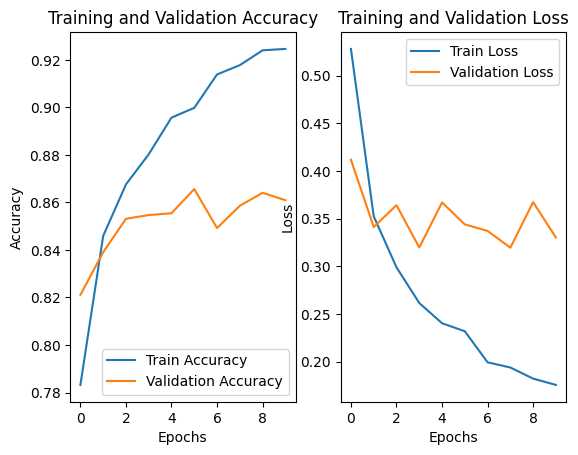

In [ ]:
# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Vẽ đồ thị Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Week 6: Ver 2 (Mô hình thay thế)

# Week 7

In [ ]:
!pip uninstall pandas -y
!pip install pandas==2.2.2


Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 75.2 MB/s eta 0:00:00


In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.17.0 --no-cache-dir

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 162.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 204.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 258.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 187.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorb

In [3]:
import tensorflow as tf

# Load mô hình Keras ban đầu
model = tf.keras.models.load_model("/content/drive/MyDrive/project/Final DPL/resnet50_finetuned.keras")

# Chuyển đổi sang TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Áp dụng quantization để giảm kích thước
tflite_model = converter.convert()

# Lưu mô hình đã chuyển đổi
with open("resnet50_finetuned.tflite", "wb") as f:
    f.write(tflite_model)

print("Mô hình đã được chuyển đổi và lưu thành công!")


Saved artifact at '/tmp/tmpeuw3oo01'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133518636298128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636298512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636301008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636301200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636298320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636300240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636301776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518636300432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518627192912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133518627193680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1335186362960

In [ ]:
!pip uninstall -y numpy


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5


In [ ]:
!pip install numpy==1.23.5


In [ ]:
import numpy as np
import tensorflow as tf

print("NumPy Version:", np.__version__)
print("TensorFlow Version:", tf.__version__)


NumPy Version: 2.1.3
TensorFlow Version: 2.19.0


In [ ]:
pip install --upgrade tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [5]:
!pip install pyngrok

In [6]:
!ngrok authtoken 2o5uG6pjrJKOkNToX8dqUNOU7Eb_4fvJHVspGzkdm6sthiVzX

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%cd /content/drive/MyDrive/project/Final DPL

In [9]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from flask import Flask, request, jsonify, render_template, Response
from pyngrok import ngrok
import time
import threading

# Global variables for performance tracking
frame_count = 0
fps_avg = 0
processing_times = []

# Convert model to TensorFlow Lite with quantization
def convert_model_to_tflite():
    try:
        model = tf.keras.models.load_model("resnet50_finetuned.keras")

        # Configure the converter with optimizations
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # Enable quantization
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.representative_dataset = representative_dataset_gen
        converter.target_spec.supported_types = [tf.int8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8

        # Convert the model
        tflite_model = converter.convert()

        # Save the model
        with open("resnet50_finetuned_quantized.tflite", "wb") as f:
            f.write(tflite_model)
        print("Model successfully converted to optimized TensorFlow Lite format")
    except Exception as e:
        print(f"Error during model conversion: {e}")

# Representative dataset for quantization
def representative_dataset_gen():
    # This function provides sample input data for quantization calibration
    # You would typically use a small subset of your training data
    for _ in range(100):
        data = np.random.rand(1, 224, 224, 3).astype(np.float32)
        yield [data]

# Setup Flask app
app = Flask(__name__)
port = 5000

# Initialize model and performance monitoring
def initialize_system():
    global interpreter, input_details, output_details

    # Load optimized TensorFlow Lite model
    try:
        model_path = "/content/drive/MyDrive/project/Final DPL/resnet50_finetuned.tflite"
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Print model details for debugging
        input_shape = input_details[0]['shape']
        input_dtype = input_details[0]['dtype']
        print(f"Model loaded successfully. Input shape: {input_shape}, dtype: {input_dtype}")

        # Start ngrok tunnel
        public_url = ngrok.connect(port).public_url
        print(f"Public URL: {public_url}")
        return public_url
    except Exception as e:
        print(f"Error initializing system: {e}")
        return None

# Image preprocessing function
def preprocess_frame(frame, batch_processing=False):
    """Preprocess frame for model input with optimizations"""
    try:
        # Resize efficiently
        resized = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)

        # Normalize to range [0,1]
        normalized = img_to_array(resized) / 255.0

        if batch_processing:
            # For batch processing, return as is
            return normalized.astype(np.float32)
        else:
            # For single frame prediction, add batch dimension
            return np.expand_dims(normalized, axis=0).astype(np.float32)
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        # Return a blank frame in case of error
        return np.zeros((1, 224, 224, 3), dtype=np.float32)

# Prediction function with TensorFlow Lite
def predict_tflite(frame):
    """Make prediction using optimized TensorFlow Lite model"""
    try:
        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], frame)

        # Run inference
        interpreter.invoke()

        # Get output
        prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]
        return prediction
    except Exception as e:
        print(f"Error during prediction: {e}")
        return 0.5  # Return middle value in case of error

# Batch prediction for multiple frames (optimization)
def batch_predict(frames, batch_size=4):
    """Process multiple frames in batches for better throughput"""
    results = []
    for i in range(0, len(frames), batch_size):
        batch = frames[i:i+batch_size]
        batch_input = np.vstack(batch)
        # Process batch
        for j in range(len(batch)):
            single_input = np.expand_dims(batch[j], axis=0)
            interpreter.set_tensor(input_details[0]['index'], single_input)
            interpreter.invoke()
            pred = interpreter.get_tensor(output_details[0]['index'])[0][0]
            results.append(pred)
    return results

# Frame generator for video streaming
def generate_frames(video_source=0, use_threading=True):
    """Real-time deepfake detection with performance optimizations"""
    global frame_count, fps_avg, processing_times

    # Initialize video capture
    cap = cv2.VideoCapture(video_source)

    # For threading optimization
    next_frame = None
    next_frame_ready = False
    processing_complete = False

    # Thread function to get next frame
    def get_next_frame():
        nonlocal next_frame, next_frame_ready
        success, frame = cap.read()
        if success:
            next_frame = frame
            next_frame_ready = True
        else:
            next_frame = None
            next_frame_ready = True

    # Start first frame capture
    if use_threading:
        frame_thread = threading.Thread(target=get_next_frame)
        frame_thread.start()

    try:
        while cap.isOpened():
            start_time = time.time()

            if use_threading:
                # Wait for thread to finish
                if frame_thread.is_alive():
                    frame_thread.join()

                if not next_frame_ready or next_frame is None:
                    break

                # Get the frame captured by the thread
                frame = next_frame
                next_frame_ready = False

                # Start capturing next frame in background
                frame_thread = threading.Thread(target=get_next_frame)
                frame_thread.start()
            else:
                # Traditional sequential frame capture
                success, frame = cap.read()
                if not success:
                    break

            # Process frame
            processed_frame = preprocess_frame(frame)
            prediction = predict_tflite(processed_frame)

            # Determine result
            label = "FAKE" if prediction > 0.5 else "REAL"
            confidence = max(prediction, 1 - prediction) * 100

            # Add visualization to frame
            color = (0, 0, 255) if label == "FAKE" else (0, 255, 0)
            cv2.putText(frame, f"{label} ({confidence:.2f}%)", (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

            # Calculate and show FPS
            process_time = time.time() - start_time
            processing_times.append(process_time)

            # Keep only recent processing times for moving average
            if len(processing_times) > 30:
                processing_times.pop(0)

            avg_process_time = sum(processing_times) / len(processing_times)
            fps = 1.0 / avg_process_time

            cv2.putText(frame, f"FPS: {fps:.2f}", (20, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

            # Add frame counter
            frame_count += 1
            cv2.putText(frame, f"Frame: {frame_count}", (20, 130),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

            # Encode and yield frame
            _, buffer = cv2.imencode('.jpg', frame)
            frame_bytes = buffer.tobytes()
            yield (b'--frame\r\n' b'Content-Type: image/jpeg\r\n\r\n' + frame_bytes + b'\r\n')

    except Exception as e:
        print(f"Error in frame generation: {e}")
    finally:
        cap.release()
#Initialize Flask app
app = Flask(__name__, template_folder="/content/drive/MyDrive/project/Final DPL/templates")

# Flask routes
@app.route("/")
def home():
    return render_template("index.html", public_url=public_url)

@app.route("/video_feed")
def video_feed():
    return Response(generate_frames(), mimetype="multipart/x-mixed-replace; boundary=frame")

@app.route("/predict", methods=["POST"])
def predict():
    try:
        file = request.files["file"]
        file_path = "static/temp.jpg"
        file.save(file_path)

        image = cv2.imread(file_path)
        processed_image = preprocess_frame(image)
        prediction = predict_tflite(processed_image)

        label = "FAKE" if prediction > 0.5 else "REAL"
        confidence = max(prediction, 1 - prediction) * 100

        return render_template("index.html",
                              prediction=label,
                              confidence=confidence,
                              image_path=file_path,
                              public_url=public_url)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route("/stats")
def stats():
    """Return performance statistics"""
    global frame_count, fps_avg, processing_times

    avg_process_time = sum(processing_times) / max(len(processing_times), 1)
    fps = 1.0 / avg_process_time if avg_process_time > 0 else 0

    return jsonify({
        "frames_processed": frame_count,
        "average_fps": fps,
        "processing_time_ms": avg_process_time * 1000
    })

# Main execution
if __name__ == "__main__":
    # Convert model if needed
    # convert_model_to_tflite()  # Uncomment to convert model

    # Initialize system
    public_url = initialize_system()

    # Run the app
    app.run(host='0.0.0.0', port=port, threaded=True)



Model loaded successfully. Input shape: [  1 224 224   3], dtype: <class 'numpy.float32'>
Public URL: https://7634-34-57-139-13.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [27/Mar/2025 02:30:08] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Mar/2025 02:30:09] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [27/Mar/2025 02:30:16] "POST /predict HTTP/1.1" 500 -


# **Week 8**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/project/Final DPL

/content/drive/MyDrive/project/Final DPL


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Load dataset
def create_data_generators(batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    df = pd.read_csv(r'/content/drive/MyDrive/project/balanced_metadata2_fixed.csv')

    print(f"Total samples: {len(df)}")
    print(f"Class distribution: \n{df['label'].value_counts()}")
    return df, train_datagen, val_datagen
df, train_datagen, val_datagen = create_data_generators()

Total samples: 8000
Class distribution: 
label
fake    4000
real    4000
Name: count, dtype: int64


In [ ]:
test_generator = val_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 1600 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Load mô hình đã lưu
model = load_model('resnet50_finetuned.keras')

# Đánh giá trên tập validation
loss, accuracy = model.evaluate(test_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 1015s 20s/step - accuracy: 0.7575 - loss: 1.8845
Validation Accuracy: 76.31%


***- Analyze errors and misclassifications using a confusion matrix***

50/50 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step


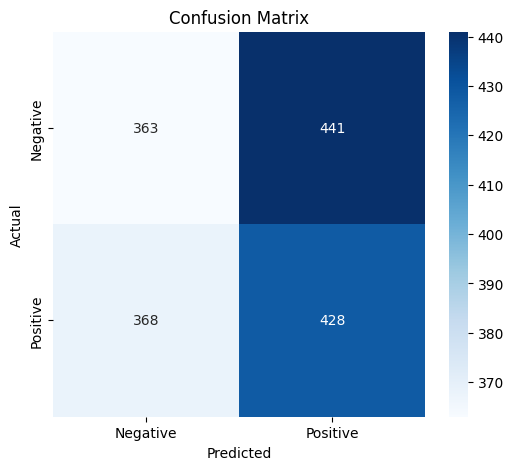

              precision    recall  f1-score   support

           0       0.50      0.45      0.47       804
           1       0.49      0.54      0.51       796

    accuracy                           0.49      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.49      0.49      0.49      1600



In [ ]:
# Lấy nhãn thực tế và dự đoán từ mô hình
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Lưu ảnh
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

# Hiển thị ảnh
plt.show()

# In báo cáo phân loại
print(classification_report(y_true, y_pred))


# ***Test EfficientNet.***

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Sử dụng Mixed Precision để tăng tốc training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Tối ưu performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)  # Bật XLA JIT compilation
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

# Load pre-trained EfficientNetB2 model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze phần lớn các layer, chỉ fine-tune 15 layer cuối
for layer in base_model.layers[:-15]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout để giảm overfitting
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Optimizer với learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Tăng batch size để tăng tốc
BATCH_SIZE = 64  # Tăng batch size lên

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/project/balanced_metadata2_fixed.csv')

# Tạo image data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Đánh giá model
loss, accuracy, auc = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Validation AUC: {auc:.4f}')

# Lưu model
model.save('efficientnet_optimized.keras')



31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9099s 91s/step - accuracy: 0.5136 - auc: 0.5128 - loss: 3.3564 - val_accuracy: 0.4975 - val_auc: 0.4937 - val_loss: 2.3689
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9038s 90s/step - accuracy: 0.5057 - auc: 0.5032 - loss: 3.7500 - val_accuracy: 0.4975 - val_auc: 0.4992 - val_loss: 2.0208
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9030s 90s/step - accuracy: 0.4860 - auc: 0.4882 - loss: 3.4023 - val_accuracy: 0.4975 - val_auc: 0.4982 - val_loss: 1.7045
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9016s 90s/step - accuracy: 0.4830 - auc: 0.4826 - loss: 3.0713 - val_accuracy: 0.4975 - val_auc: 0.5106 - val_loss: 1.6618
Epoch 5/10
 84/100 ━━━━━━━━━━━━━━━━━━━━ 21:29 81s/step - accuracy: 0.5038 - auc: 0.4950 - loss: 2.3618

In [ ]:
# Hàm để lấy dự đoán từ generator
def get_predictions(generator, model):
    # Reset generator trước khi lấy dữ liệu
    generator.reset()

    # Lấy số batches từ generator
    steps = len(generator)

    # Lấy true labels
    y_true = []
    for i in range(steps):
        batch_x, batch_y = next(generator)
        y_true.extend(batch_y)

    # Reset generator lại để dự đoán
    generator.reset()

    # Dự đoán
    y_pred_prob = model.predict(generator, steps=steps, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    return np.array(y_true), y_pred

# Lấy dự đoán từ validation set
print("Generating predictions for confusion matrix...")
y_true, y_pred = get_predictions(validation_generator, model)

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Vẽ confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_EfficientNet.png')
plt.show()

# In classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Vẽ ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Vẽ training & validation history
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Vẽ precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig('precision_recall_curve_EfficientNet.png')
plt.show()

print("\nEvaluation Complete. Results saved as images.")